In [53]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.13.6
# ---

# # Helmholtz equation
#
# Copyright (C) 2018 Samuel Groth
#
# Helmholtz problem in both complex and real modes
# In the complex mode, the exact solution is a plane wave propagating at
# an angle theta to the positive x-axis. Chosen for comparison with
# results from Ihlenburg's book "Finite Element Analysis of Acoustic
# Scattering" p138-139. In real mode, the Method of Manufactured
# Solutions is used to produce the exact solution and source term.

from mpi4py import MPI
from petsc4py import PETSc

# +
import numpy as np

import ufl
from dolfinx.fem import Function, assemble_scalar, form, functionspace
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.mesh import create_unit_square
from ufl import dx, grad, inner

# Wavenumber
k0 = 1 * np.pi

# Approximation space polynomial degree
deg = 1

# Number of elements in each direction of the mesh
n_elem = 16

msh = create_unit_square(MPI.COMM_WORLD, n_elem, n_elem)

# Source amplitude
if np.issubdtype(PETSc.ScalarType, np.complexfloating):  # type: ignore
    A = PETSc.ScalarType(1 + 1j)  # type: ignore
else:
    A = 1

# Test and trial function space
V = functionspace(msh, ("Lagrange", deg))

# Define variational problem
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = Function(V)
f.interpolate(lambda x: A * k0**2 * np.cos(k0 * x[0]) * np.cos(k0 * x[1]))
a = inner(grad(u), grad(v)) * dx - k0**2 * inner(u, v) * dx
L = inner(f, v) * dx

# Compute solution
uh = Function(V)
uh.name = "u"
problem = LinearProblem(a, L, u=uh, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
problem.solve()

# Save solution in XDMF format (to be viewed in ParaView, for example)
with XDMFFile(
    MPI.COMM_WORLD, "out_helmholtz/plane_wave.xdmf", "w", encoding=XDMFFile.Encoding.HDF5
) as file:
    file.write_mesh(msh)
    file.write_function(uh)
# -

# Calculate $L_2$ and $H^1$ errors of FEM solution and best
# approximation. This demonstrates the error bounds given in Ihlenburg.
# Pollution errors are evident for high wavenumbers.

# +
# Function space for exact solution - need it to be higher than deg
V_exact = functionspace(msh, ("Lagrange", deg + 10))
u_exact = Function(V_exact)
u_exact.interpolate(lambda x: A * np.cos(k0 * x[0]) * np.cos(k0 * x[1]))

# H1 errors
diff = uh - u_exact
H1_diff = msh.comm.allreduce(assemble_scalar(form(inner(grad(diff), grad(diff)) * dx)), op=MPI.SUM)
H1_exact = msh.comm.allreduce(
    assemble_scalar(form(inner(grad(u_exact), grad(u_exact)) * dx)), op=MPI.SUM
)
print("Relative H1 error of FEM solution:", abs(np.sqrt(H1_diff) / np.sqrt(H1_exact)))

# L2 errors
L2_diff = msh.comm.allreduce(assemble_scalar(form(inner(diff, diff) * dx)), op=MPI.SUM)
L2_exact = msh.comm.allreduce(assemble_scalar(form(inner(u_exact, u_exact) * dx)), op=MPI.SUM)
print("Relative L2 error of FEM solution:", abs(np.sqrt(L2_diff) / np.sqrt(L2_exact)))

Relative H1 error of FEM solution: 0.09882296459626397
Relative L2 error of FEM solution: 0.025833090781093433


In [54]:
V_exact

FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False), (2,)), 7), Basix element (P, triangle, 11, gll_warped, unset, False))

4.934802212238119

In [46]:
V_exact

FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False), (2,)), 2), Basix element (P, triangle, 4, gll_warped, unset, False))

In [55]:
tdim = msh.topology.dim
tdim

2

In [56]:
import pyvista


In [42]:
from dolfinx import plot
pyvista.start_xvfb()
topology, cell_types, geometry = plot.vtk_mesh(msh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)



No module named 'trame'

Falling back to a static output.
  warnings.warn(



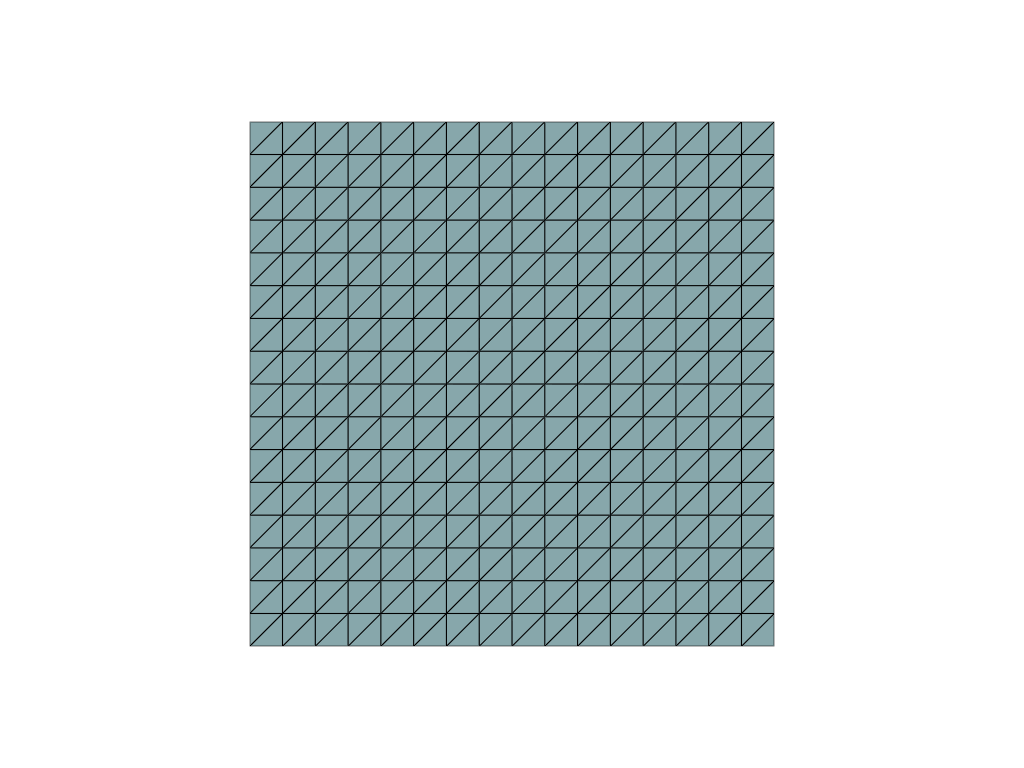

In [43]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")


No module named 'trame'

Falling back to a static output.
  warnings.warn(



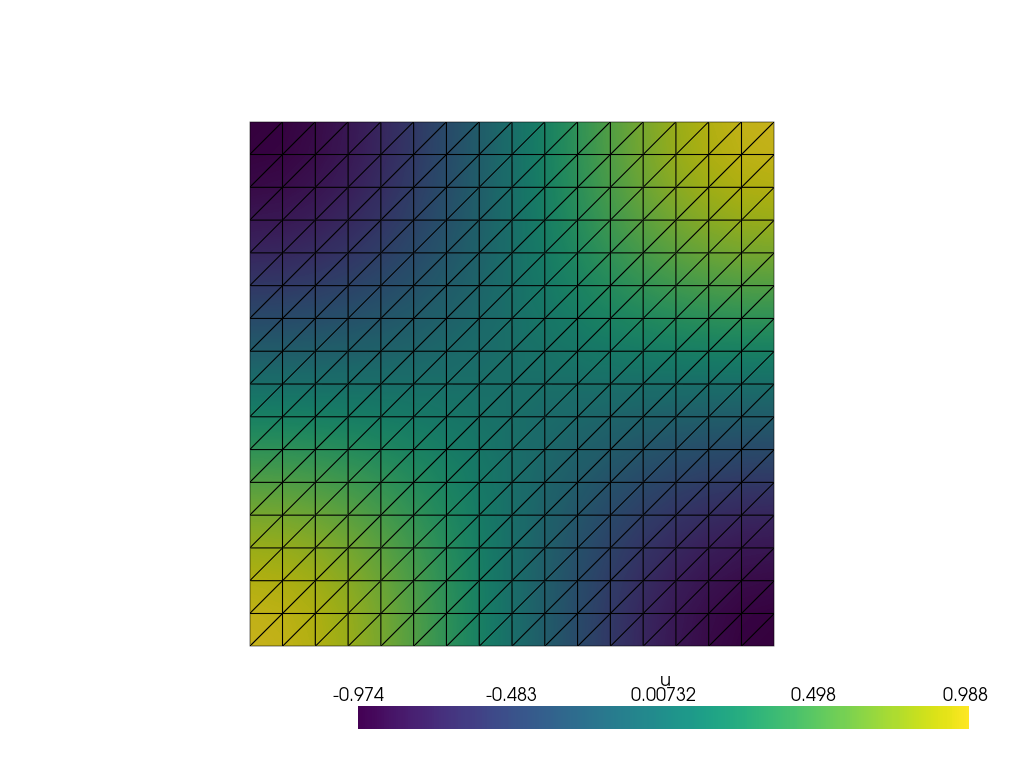

In [44]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [3]:
import gmsh
gmsh.initialize()
gmsh.model.add("test1")

lc = 0.5# 网格尺寸

gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1, 0, 0, lc, 2)
gmsh.model.geo.addPoint(1, 1, 0, lc, 3)
gmsh.model.geo.addPoint(0, 1, 0, lc, 4)

gmsh.model.geo.addLine(1, 2, 1) # 线
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)

gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
gmsh.model.geo.addPlaneSurface([1], 1)

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

gmsh.write("test1.msh")

gmsh.fltk.run()
gmsh.finalize()


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000692911s, CPU 0.001383s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000655997s, CPU 0.000637s)
Info    : 12 nodes 26 elements
Info    : Writing 'test1.msh'...
Info    : Done writing 'test1.msh'


Error   : Can't open display:  (FLTK internal error)


Exception: Can't open display:  (FLTK internal error)